Dataset preview:
    R&D Spend  Administration  Marketing Spend       State     Profit
0  165349.20       136897.80        471784.10    New York  192261.83
1  162597.70       151377.59        443898.53  California  191792.06
2  153441.51       101145.55        407934.54     Florida  191050.39
3  144372.41       118671.85        383199.62    New York  182901.99
4  142107.34        91391.77        366168.42     Florida  166187.94

Missing values in each column:
 R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64



Model Evaluation:
MSE: 82010363.05, R^2: 0.90



Regression Formula:
Profit(y) = 111688.86 + (-315.26 x Dummy State 1) + (623.53 x Dummy State 2) + (-308.27 x Dummy State 3) + (36608.57 x R&D Spend) + (-1907.92 x Administration) + (3614.34 x Marketing)

Predicted Profit for example input: 230141.38


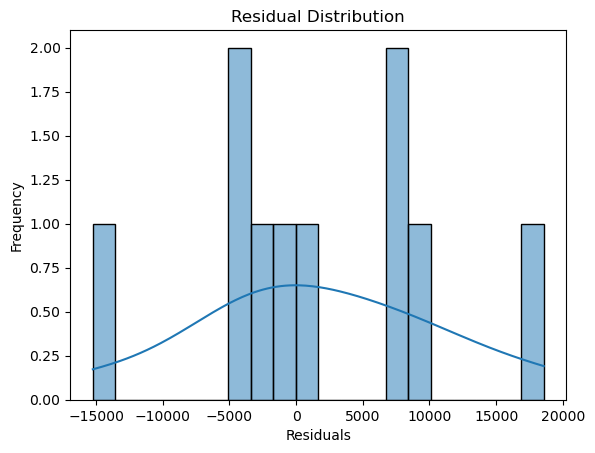

In [5]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the dataset
df = pd.read_csv('50_Startups.csv')

# Display the first few rows
print("Dataset preview:\n", df.head())

# Check for null values
print("\nMissing values in each column:\n", df.isnull().sum())

# Boxplots for distributions of variables
features = ['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']
fig_one = make_subplots(rows=2, cols=2, subplot_titles=features)
positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for feature, pos in zip(features, positions):
    trace = go.Box(y=df[feature], name=feature)
    fig_one.add_trace(trace, row=pos[0], col=pos[1])

fig_one.update_layout(height=600, width=800, title_text="Box Plots for Distributions")
fig_one.show()

# Prepare the independent (X) and dependent (y) variables
X = df.drop('Profit', axis=1)
y = df['Profit'].to_numpy()

# Encode categorical variable 'State' using OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['State'])], remainder='passthrough')
X_encoded = np.array(ct.fit_transform(X))

# Standardize numerical features
scaler = StandardScaler()
X_encoded[:, 3:] = scaler.fit_transform(X_encoded[:, 3:])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train a Multiple Linear Regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Evaluate the model
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:\nMSE: {mse:.2f}, R^2: {r2:.2f}")

# Combine predicted and actual values for visualization
comparison_data = {
    'Observed Profit': y_test,
    'Predicted Profit': y_pred
}
df_comparison = pd.DataFrame(comparison_data)
df_comparison['Difference'] = abs(df_comparison['Observed Profit'] - df_comparison['Predicted Profit'])

# Scatterplot of observed vs. predicted profits
fig_two = px.scatter(df_comparison,
                     x='Observed Profit',
                     y='Predicted Profit',
                     size='Difference',
                     color='Difference',
                     color_continuous_scale='emrld',
                     trendline='ols',
                     trendline_color_override="forestgreen",
                     title="Observed vs Predicted Profits")
fig_two.show()

# Print the regression formula
reg_coef = regressor.coef_
reg_intercept = regressor.intercept_

features_encoded = ['Dummy State 1', 'Dummy State 2', 'Dummy State 3', 'R&D Spend', 'Administration', 'Marketing']
formula = f"Profit(y) = {reg_intercept:.2f}"
for i, coef in enumerate(reg_coef):
    formula += f" + ({coef:.2f} x {features_encoded[i]})"
print("\nRegression Formula:")
print(formula)

# Single prediction example
example_input = np.array([[0, 0, 1, 250000, 150000, 600000]])  # State = New York, R&D Spend=250K, Admin=150K, Marketing=600K

# Apply scaling to numerical features
example_input[:, 3:] = scaler.transform(example_input[:, 3:])

# Predict profit
predicted_profit = regressor.predict(example_input)
print(f"\nPredicted Profit for example input: {predicted_profit[0]:.2f}")
# Residual analysis
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, bins=20)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
